In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [2]:
%cd gdrive/My\ Drive/nlp/
!ls

/content/gdrive/My Drive/nlp
test.csv  train.csv


In [1]:
# %pip install nltk wordcloud
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from scipy.sparse import hstack
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/ilya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ilya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ilya/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/ilya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df_train = pd.read_csv('train.csv').fillna(' ')
df_test = pd.read_csv('test.csv').fillna(' ')

df_train.keyword = df_train.keyword.str.replace("%20", " ")
df_test.keyword = df_test.keyword.str.replace("%20", " ")


# Data preprocessing

In [4]:
df_train.text = df_train.text.str.encode('ascii', 'ignore').str.decode("ascii")
df_test.text = df_test.text.str.encode('ascii', 'ignore').str.decode("ascii")
df_train.text = df_train.text.apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))
df_test.text = df_test.text.apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))

In [5]:
def preprocess_news(df):
    stops = set(stopwords.words('english'))
    new_corpus=[]

    lem=WordNetLemmatizer()
    for text in df["text"]:
        words=[w for w in word_tokenize(text) if (w not in stops)]

        words=[lem.lemmatize(w) for w in words]

        new_corpus += words
    return set(new_corpus)

In [6]:
corpus = preprocess_news(df_train)

In [7]:
corpus #Unique words

{'Fiona',
 'creepiest',
 '20',
 'fishing',
 'PB',
 'Some',
 'versethe',
 '10km',
 '30th',
 'ADIDAS',
 'grilled',
 'milita',
 'Diesel',
 'opinion',
 'Ranking',
 'bliss',
 'Nathan',
 'Poisoned',
 'Lethal',
 'allegedly',
 'AUG',
 'Dead',
 'morbid',
 'Namekians',
 'FROM',
 'reckless',
 'SPYING',
 'coya',
 'bombing',
 'Kanye',
 'ghe',
 'hosting',
 'Only',
 'Cold',
 'Rockstar',
 'ABBOTT',
 'Electrocuted',
 'talk',
 'reference',
 'Chairman',
 'Effects',
 '8',
 'debt',
 'forfeiting',
 'Stuart',
 '3D',
 'wonderfully',
 'Updated',
 'privacy',
 'nearing',
 'RAN',
 'declares',
 'film',
 '27W',
 'Couple',
 'Payday',
 'Ironically',
 'blessing',
 'LOL',
 'overturned',
 'Sterling',
 'snake',
 'IF',
 'marquis',
 'IS',
 'Shaker',
 'na',
 'FollowNFLNews',
 'information',
 'Sikh',
 'Horror',
 '3460',
 'dried',
 'forefather',
 'Glimpses',
 'Challenges',
 'Rebahe',
 'Amiibos',
 'Planetary',
 'tidal',
 'mark',
 'KS94',
 'dawgs',
 'facility',
 'JAMAICA',
 'Dying',
 'Bento',
 'NowPlaying',
 'Harper',
 'Gore',


In [8]:
def preprocess(text):
    stops = set(stopwords.words('english'))

    lem=WordNetLemmatizer()

    words=[w for w in word_tokenize(text) if (w not in stops)]

    words=[lem.lemmatize(w) for w in words]
   
    return words

In [9]:
df_train.text = df_train.text.apply(lambda x: ' '.join(preprocess(x)))
df_test.text = df_test.text.apply(lambda x: ' '.join(preprocess(x)))

# EDA

## Target and not target records count

0    4342
1    3271
Name: target, dtype: int64


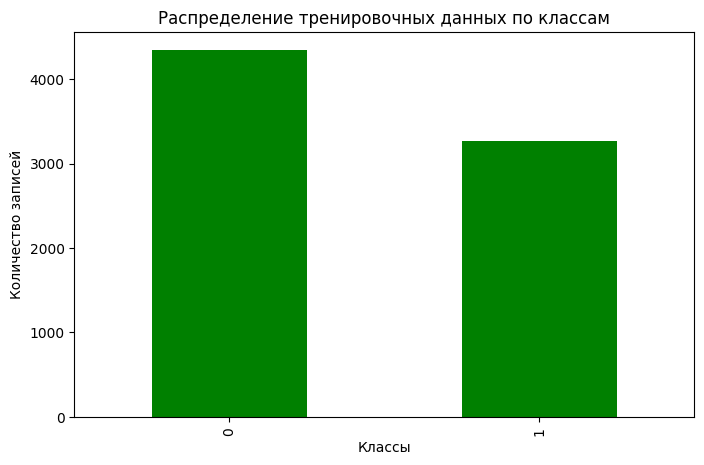

In [10]:
plt.figure(figsize=(8,5))
df_train['target'].value_counts().plot(kind='bar',color='green')
plt.title('Распределение тренировочных данных по классам')
plt.xlabel('Классы')
plt.ylabel('Количество записей')
print(df_train['target'].value_counts())

## Keywords statistics

<AxesSubplot:title={'center':'Распределение ключевых слов в тренировочных данных'}, xlabel='Количество', ylabel='Ключевые слова'>

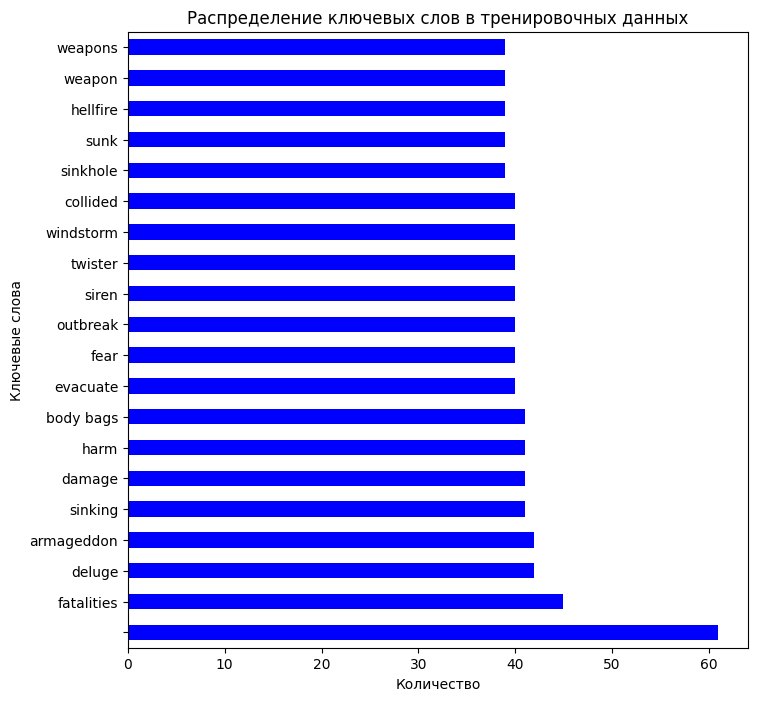

In [11]:
plt.figure(figsize=(8,8))
plt.title('Распределение ключевых слов в тренировочных данных')
plt.xlabel('Количество')
plt.ylabel('Ключевые слова')
df_train['keyword'].value_counts()[:20].plot(kind='barh',color='blue')

## Locations statistics

<AxesSubplot:title={'center':'Распределение по геолокации'}, xlabel='Количество', ylabel='Основные точки геолокации'>

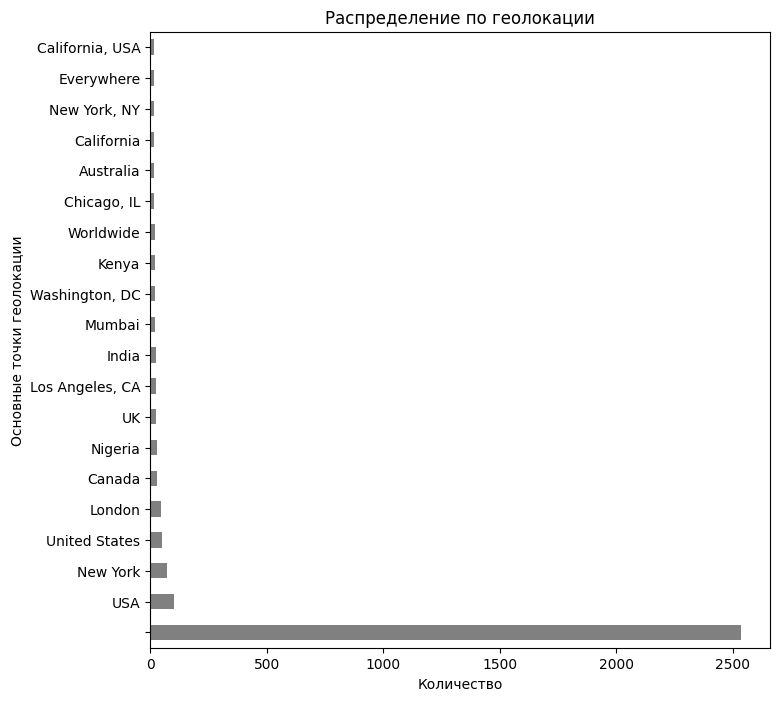

In [12]:
plt.figure(figsize=(8,8))
plt.title('Распределение по геолокации')
plt.xlabel('Количество')
plt.ylabel('Основные точки геолокации')
df_train['location'].value_counts()[:20].plot(kind='barh',color='grey')

## Disaster and Non Disaster tweets length

Text(0, 0.5, 'Количество твитов')

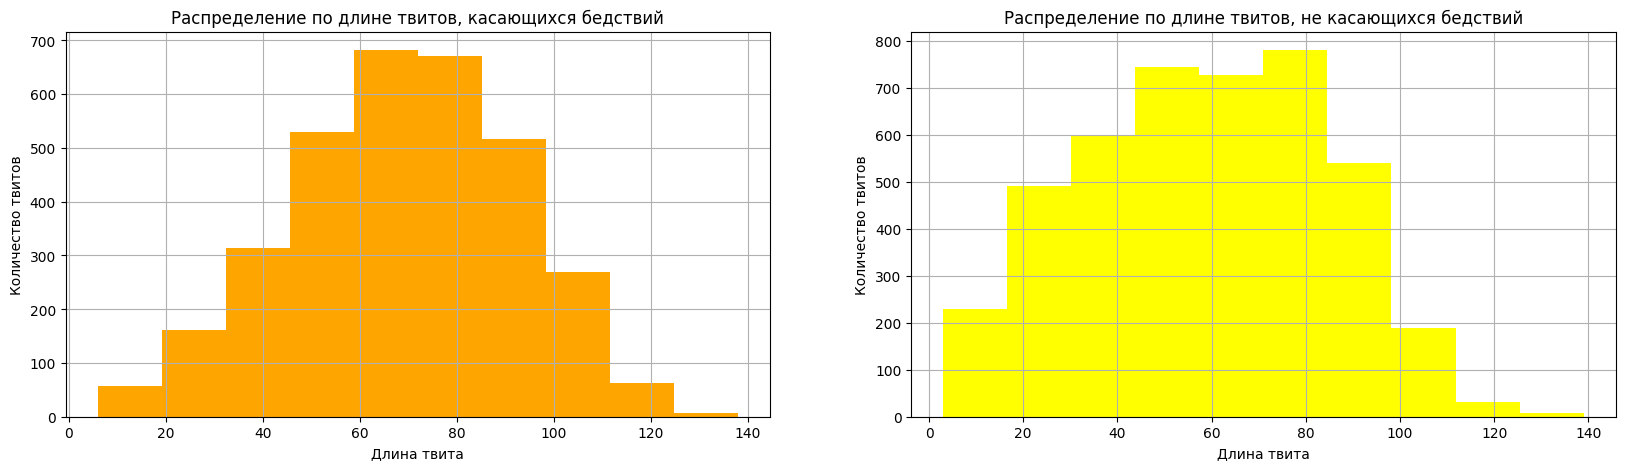

In [13]:
tweet_dis = df_train[df_train['target']==1]
tweet_ndis = df_train[df_train['target']==0]
len_dis = tweet_dis.text.str.len()
len_ndis = tweet_ndis.text.str.len()

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(len_dis,color='orange')
plt.grid()
plt.title('Распределение по длине твитов, касающихся бедствий')
plt.xlabel('Длина твита')
plt.ylabel('Количество твитов')
plt.subplot(1,2,2)
plt.hist(len_ndis,color='yellow',)
plt.grid()
plt.title('Распределение по длине твитов, не касающихся бедствий')
plt.xlabel('Длина твита')
plt.ylabel('Количество твитов')

## Disaster and Non Disaster word length

Text(0, 0.5, 'Количество слов')

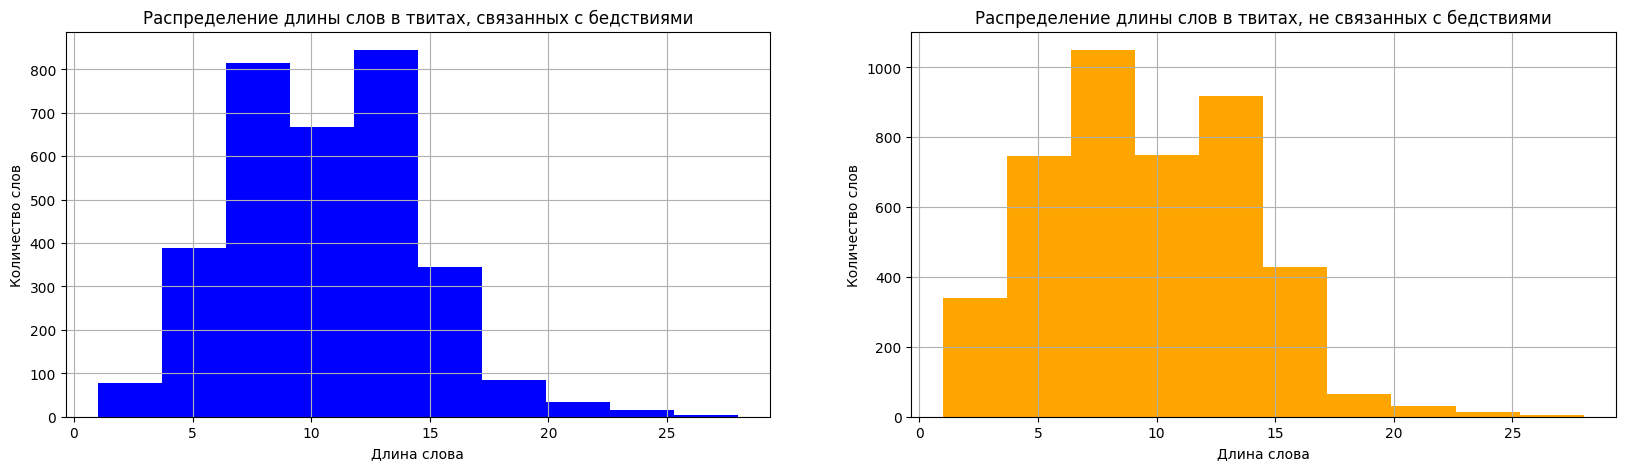

In [14]:
words_dis = df_train[df_train['target']==1]['text'].str.split().map(lambda x:len(x))
words_ndis = df_train[df_train['target']==0]['text'].str.split().map(lambda x:len(x))
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(words_dis,color='blue')
plt.grid()
plt.title('Распределение длины слов в твитах, связанных с бедствиями')
plt.xlabel('Длина слова')
plt.ylabel('Количество слов')
plt.subplot(1,2,2)
plt.hist(words_ndis,color='orange',)
plt.grid()
plt.title('Распределение длины слов в твитах, не связанных с бедствиями')
plt.xlabel('Длина слова')
plt.ylabel('Количество слов')

# Cloud of words

## Keywords

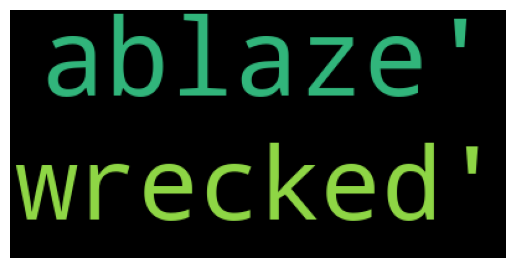

In [15]:
text = df_train.query('keyword!=" "').keyword.values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Locations

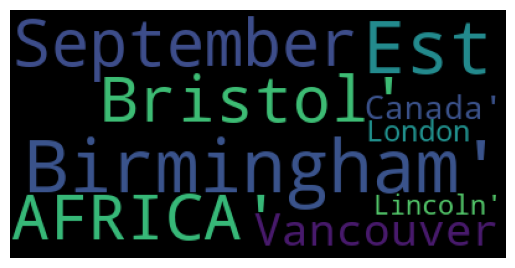

In [16]:
text = df_train.query('location!=" "').location.values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Text

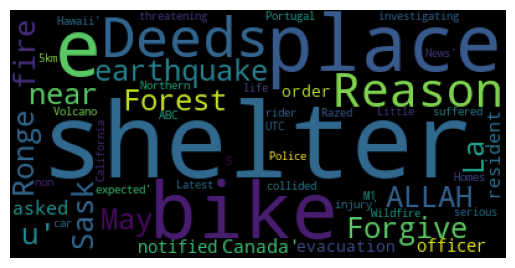

In [17]:
text = df_train.text.values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# sklearn.CountVectorize

In [18]:
count_vectorizer = feature_extraction.text.CountVectorizer()

train_vectors = count_vectorizer.fit_transform(df_train["text"])
test_vectors = count_vectorizer.transform(df_test["text"])

In [19]:
print(train_vectors[0].todense().shape)
print(test_vectors[0].todense().shape)

train_vectors_df = pd.DataFrame(train_vectors.todense())
train_vectors_df.head()

(1, 14384)
(1, 14384)


,0,1,2,3,4,5,6,7,8,9,...,14374,14375,14376,14377,14378,14379,14380,14381,14382,14383
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
test_vectors_df = pd.DataFrame(test_vectors.todense())
test_vectors_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14374,14375,14376,14377,14378,14379,14380,14381,14382,14383
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Graphics

In [21]:
count_vectorizer = feature_extraction.text.CountVectorizer()

train_vectors = count_vectorizer.fit_transform(df_train["text"])
features = count_vectorizer.get_feature_names_out()

train_vectors_df = pd.DataFrame(train_vectors.todense())
train_vectors_df = train_vectors_df.rename(columns={i: features[i] for i in range(len(features))})
train_vectors_df

,00,000,0000,00end,00pm,01,02,0215,02pm,03,...,zone,zonewolf123,zoom,zotar,zouma,zrnf,zss,zumiez,zurich,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Частота')

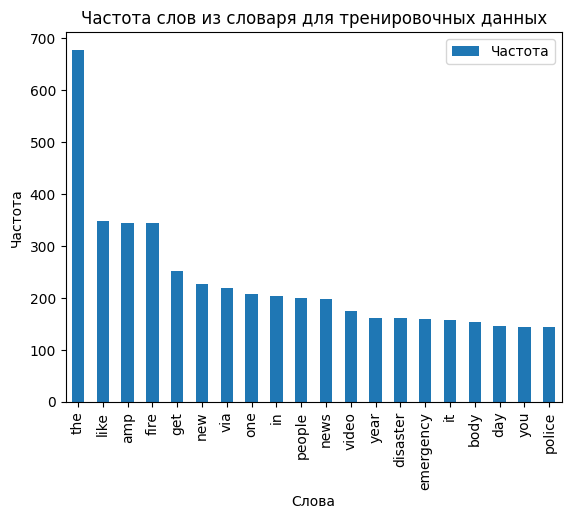

In [22]:
pd.DataFrame(train_vectors.sum(axis=0).T,
             index=count_vectorizer.get_feature_names_out(),
             columns=['Частота']).sort_values(by='Частота',
                                           ascending=False).head(20) \
             .plot(kind='bar',title="Частота слов из словаря для тренировочных данных")
plt.xlabel('Слова')
plt.ylabel('Частота')

In [23]:
count_vectorizer = feature_extraction.text.CountVectorizer()
test_vectors = count_vectorizer.fit_transform(df_test["text"])
features = count_vectorizer.get_feature_names_out()
test_vectors_df = pd.DataFrame(test_vectors.todense())
test_vectors_df = test_vectors_df.rename(columns={i: features[i] for i in range(len(features))})
test_vectors_df

,00,000,0000,00am,00pm,01,02,02pm,03,032,...,zionist,zippers,zirngast,zix,zombie,zone,zouis,zouma,zuma,zx
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Частота')

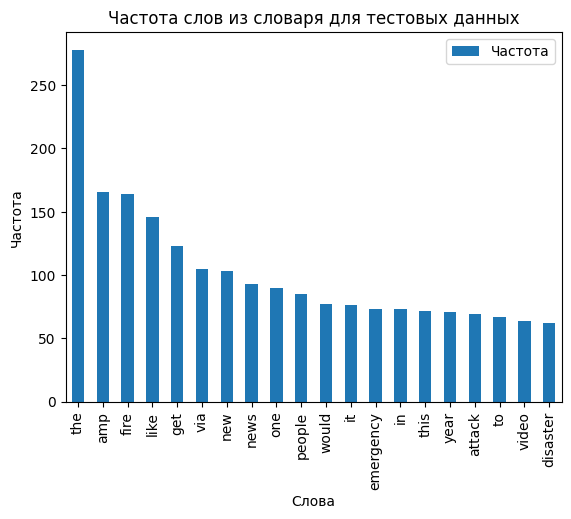

In [25]:
pd.DataFrame(test_vectors_df.sum(axis=0).T,
             index=count_vectorizer.get_feature_names_out(),
             columns=['Частота']).sort_values(by='Частота',
                                           ascending=False).head(20) \
             .plot(kind='bar',title="Частота слов из словаря для тестовых данных")
plt.xlabel('Слова')
plt.ylabel('Частота')

# TF-IDF

In [ ]:
train_text = df_train['text']
test_text = df_test['text']
summary_text = pd.concat([train_text, test_text])

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(summary_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [ ]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(summary_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

In [ ]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

In [ ]:
train_features.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
train_oof = np.zeros(df_train.shape[0],)
kf = KFold(n_splits=5, random_state=137, shuffle=True)
test_preds = 0

for jj, (train_index, val_index) in enumerate(kf.split(train_features)):
        print("Fitting fold", jj+1)
        train_x = train_features.toarray()[train_index]
        val_x = train_features.toarray()[val_index]
        train_target = df_train['target'].values[train_index]
        classifier = LogisticRegression(solver='sag')
        classifier.fit(train_x, train_target)
        train_oof[val_index] = classifier.predict_proba(val_x)[:,1]
        test_preds += classifier.predict_proba(test_features)[:,1]/5
        
print(roc_auc_score(df_train['target'].values, train_oof))

Fitting fold 1
Fitting fold 2


In [ ]:
submission =pd.read_csv('sample_submission.csv')
submission.head()

In [85]:
submission['target'] = 1*(test_preds > 0.5)
submission.head()

NameError: name 'test_preds' is not defined

In [ ]:
from sklearn.metrics import recall_score
print("RECALL:", recall_score(y_true=df_train['target'],
                              y_pred=pd.Series(1*(train_oof > 0.5))),
      )
print("ROC_AUC:", roc_auc_score(df_train['target'].values, train_oof))